In [10]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [488]:
full_regression_data = pickle.load( open( "full_regression_data.pkl", "rb" ) )

In [489]:
df = full_regression_data

In [490]:
df['log_num_weeks'] = df.num_weeks.apply(np.log)

# accounting for OUTLIERS

after some inspection, i realized that there are some specific types of films stay in theatres for ever! this is unrepresentative of the phenomenon i am intending to model, a different class entirely. 

In [491]:
df_normal = df[df['num_weeks']<=30]
df_long = df[df['num_weeks']>30]

In [357]:
print df_normal[['weekly_gross1','rank1', 'num_theaters1']].mean()
print df_long[['weekly_gross1','rank1', 'num_theaters1']].mean()

weekly_gross1    8098264.382776
rank1                 32.596819
num_theaters1        928.267597
dtype: float64
weekly_gross1    173687.726027
rank1                59.214286
num_theaters1         9.486111
dtype: float64


# analyzing num weeks relationship to ratings

In [358]:
df_normal.groupby('rating').log_num_weeks.mean()

rating
G                1.978074
NC-17            2.202001
Not Yet Rated    1.684546
PG               1.912327
PG-13            1.979338
R                1.824862
Unknown          0.895880
Unrated          1.853833
Name: log_num_weeks, dtype: float64

# Adding a months feature to the df, then dummy for each month

In [492]:
df_normal['release_month'] = df_normal.release_date.apply(lambda row: row.month)

/Users/justinstewart/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [361]:
df_normal.groupby('release_month').log_num_weeks.mean()

release_month
1     1.931758
2     1.982209
3     2.027805
4     2.000889
5     2.047687
6     2.130075
7     2.077903
8     1.938143
9     1.871902
10    1.782442
11    1.607233
12    1.001689
Name: log_num_weeks, dtype: float64

In [493]:
month_dummies = pd.get_dummies(df_normal.release_month).drop([12],axis=1)

In [494]:
month_dummies.columns = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov']

In [495]:
df_normal = pd.concat([df_normal,month_dummies],axis=1)

# theory, there are different types of films, characterized by low budget, low theatres. accounting for low theatre count and high theatre counts== different movie types!

In [403]:
df_normal[df_normal.num_theaters1 > 50][['weekly_gross1','rank1', 'num_theaters1']].mean()

weekly_gross1    15613662.956292
rank1                   6.925908
num_theaters1        1783.099664
dtype: float64

In [404]:
df_normal[df_normal.num_theaters1 <= 50][['weekly_gross1','rank1', 'num_theaters1']].mean()

weekly_gross1    84873.360342
rank1               61.090714
num_theaters1        6.828113
dtype: float64

In [496]:
df_normal['high_theatre_count'] = np.where(df_normal.num_theaters1 > 50,'True','False')

In [497]:
theatre_dummies = pd.get_dummies(df_normal.pop('high_theatre_count'))

In [506]:
theatre_dummies['True'].columns = 'high_theatre_count'

In [507]:
theatre_dummies.head()

,False,True
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1


# looking into using diffs instead of abs 

In [338]:
r = df_normal.rank2-df_normal.rank1
g = df_normal.weekly_gross9-df_normal.weekly_gross1
t = df_normal.num_theaters3-df_normal.num_theaters1
y = df_normal.num_weeks
lny = df_normal.log_num_weeks

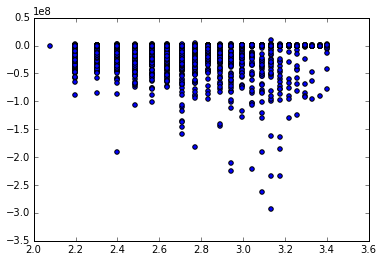

In [339]:
plt.scatter(lny,g)

In [499]:
diffs = []
for i in range(3):
    cols = [tuple((12*i)+np.array([8+j-1,8+j])) for j in range(1,12)]
    for a,b in cols:
        diffs.append(df_normal.iloc[:,b] - df_normal.iloc[:,a])
        

In [500]:
diffs = pd.DataFrame(diffs).T

In [501]:
diff_names = ['diff_gross1', 'diff_gross2', 'diff_gross3','diff_gross4','diff_gross5','diff_gross6',
 'diff_gross7',
 'diff_gross8',
 'diff_gross9',
 'diff_gross10',
 'diff_gross11',
 'diff_theaters1',
 'diff_theaters2',
 'diff_theaters3',
 'diff_theaters4',
 'diff_theaters5',
 'diff_theaters6',
 'diff_theaters7',
 'diff_theaters8',
 'diff_theaters9',
 'diff_theaters10',
 'diff_theaters11',
 'diff_rank1',
 'diff_rank2',
 'diff_rank3',
 'diff_rank4',
 'diff_rank5',
 'diff_rank6',
 'diff_rank7',
 'diff_rank8',
 'diff_rank9',
 'diff_rank10',
 'diff_rank11']

In [502]:
diffs.columns = diff_names

# Cleaned full featured regression data

In [503]:
features = pd.concat([month_dummies,theatre_dummies['True'],diffs],axis=1)

In [508]:
features.rename(columns = {'True':'high_theatre_count'})

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,...,diff_rank2,diff_rank3,diff_rank4,diff_rank5,diff_rank6,diff_rank7,diff_rank8,diff_rank9,diff_rank10,diff_rank11
0,0,0,0,0,0,1,0,0,0,0,...,4,0,3,5,5,2,6,4,6,7
1,0,0,0,0,0,0,0,0,0,1,...,-8,7,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0,0,0,1,0,0,0,0,...,7,2,3,5,17,6,12,-17,3,NaN
3,0,0,0,0,0,0,0,0,0,0,...,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,0,0,0,0,0,0,0,0,1,...,7,7,14,28,34,-53,17,NaN,NaN,NaN
7,0,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,1,0,0,0,0,0,0,0,0,...,18,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,0,0,0,0,1,0,0,0,0,...,13,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
feature